## Siamese Neural Networks 
### for Supervised Clustering of High Dimensional Spaces

In [1]:
# from palmerpenguins import load_penguins
# penguins = load_penguins()

# print(penguins.shape)
# penguins.head()

In [2]:
import pandas as pd

# DOWNLOAD DATSET HERE: https://www.kaggle.com/husainsb/lendingclub-issued-loans
loans = pd.read_csv("../data/lc_loan.csv")

print(loans.shape)
loans.head()

/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(887379, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# loans["default"] = loans["loan_status"] == "Default"
loans["issue_year"] = [int(x[1]) for x in loans["issue_d"].str.split("-")]

loans = loans[loans["issue_year"] == 2015]
loans.dropna(axis=1, how="all", inplace=True)

In [4]:
loans.shape

(421094, 75)

In [ ]:
# sns.pairplot(loans, hue='species')

In [5]:
from sklearn.model_selection import train_test_split

loans_sample, _ = train_test_split(
    loans,
    test_size=0.97,
    stratify=loans["loan_status"])

In [6]:
loans_sample.shape

(12632, 75)

## Tabular Learner

Before we train the Tabular Siamese Learner we will train baseline Tabular Learner for species classification... (why do we do this, exactly? can we just instantiate a Tabular Siamese Learner without a baseline Tabular Learner ???)

Ah yes, to init a new `TabularSiameseModel` we need to provide an `encoder` and `head` and the Tabular Learner will act as the `encoder` we init the `TabularSiameseModel` with.

In [7]:
# # from sklearn.model_selection import train_test_split

# penguins_train, penguins_test = train_test_split(
#     penguins,
#     test_size=0.10,
#     stratify=penguins["species"])

# penguins_train.shape, penguins_test.shape

# df = penguins_train.copy()

# exclude_vars = ["year"]

In [8]:
from sklearn.model_selection import train_test_split

loans_train, loans_test = train_test_split(
    loans_sample,
    test_size=0.10,
    stratify=loans_sample["loan_status"])

loans_train.shape, loans_test.shape

df = loans_train.copy()

exclude_vars = ["id", "member_id", "loan_status", "url", "last_pymnt_d", "next_pymnt_d", "policy_code", "issue_year"]

In [9]:
from fastai.tabular.all import CategoryBlock
                                
# y_names = ["species"]
y_names = ["loan_status"]
y_block = CategoryBlock()

In [10]:
from mobius.utils import emb_sz_rule

cat_names = [x for x in df.select_dtypes(exclude=['int', 'float']).columns if x != y_names]
cat_names = [x for x in cat_names if x not in exclude_vars]

# calc embedding sizes for each categorical feature
emb_szs = {k: emb_sz_rule(len(df[k].unique())) for k in cat_names}
emb_szs

{'term': 2,
 'grade': 5,
 'sub_grade': 12,
 'emp_title': 212,
 'emp_length': 6,
 'home_ownership': 3,
 'verification_status': 3,
 'issue_d': 6,
 'pymnt_plan': 2,
 'desc': 2,
 'purpose': 7,
 'title': 7,
 'zip_code': 68,
 'addr_state': 14,
 'earliest_cr_line': 53,
 'initial_list_status': 2,
 'last_credit_pull_d': 7,
 'application_type': 2,
 'verification_status_joint': 3}

In [11]:
import numpy as np

cont_names = [x for x in df.select_dtypes([np.number]).columns if x != y_names]
cont_names = [x for x in cont_names if x not in exclude_vars]
cont_names

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [12]:
from fastai.tabular.all import (Categorify, CategoryBlock, FillMissing,
                                Normalize, TabDataLoader, TabularPandas,
                                tabular_config, tabular_learner)

procs = [FillMissing, Categorify, Normalize]

In [13]:
from fastai.data.core import range_of
from fastai.tabular.all import RandomSplitter

# # train/test split
splits = RandomSplitter(valid_pct=0.10)(range_of(df))

In [14]:
tabular_pandas = TabularPandas(
        df,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=y_names,
        y_block=y_block,
        splits=splits,
        device="cpu")

In [15]:
trn_dl = TabDataLoader(
    tabular_pandas.train,
    bs=128,
    shuffle=True,
    drop_last=True,)
#     num_workers=1)

val_dl = TabDataLoader(
    tabular_pandas.valid,
    bs=128,)
#     num_workers=1)

In [16]:
from fastai.data.core import DataLoaders

dls = DataLoaders(trn_dl, val_dl)

print("Sample batch:")
dls.one_batch()

Sample batch:


(tensor([[ 2,  5, 25,  ...,  2,  2,  2],
         [ 1,  3, 13,  ...,  1,  1,  1],
         [ 2,  4, 16,  ...,  2,  2,  2],
         ...,
         [ 1,  1,  4,  ...,  2,  2,  2],
         [ 1,  2,  6,  ...,  2,  2,  2],
         [ 1,  1,  5,  ...,  2,  2,  2]]),
 tensor([[-0.5425, -0.5425, -0.5420,  ..., -0.1166, -0.1095,  0.0101],
         [-1.3147, -1.3147, -1.3144,  ..., -0.1166,  3.1108, -1.5820],
         [ 1.6212,  1.6212,  1.6225,  ..., -0.1166, -0.1095,  0.0101],
         ...,
         [-0.0816, -0.0816, -0.0809,  ..., -0.1166, -0.1095,  0.0101],
         [-1.1972, -1.1972, -1.1969,  ..., -0.1166, -0.1095,  0.0101],
         [-0.7275, -0.7275, -0.7270,  ..., -0.1166, -0.1095,  0.0101]]),
 tensor([[1],
         [1],
         [1],
         [1],
         [1],
         [3],
         [1],
         [4],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [5],
         [1],
         [1],
         [1],
         [1],
  

In [17]:
from fastai.metrics import F1Score, Precision, Recall, accuracy

# load the tabular_pandas data through the tabular_learner
layers = [2048, 1024, 32, 2]

# tabular learner configuration
config = tabular_config(ps=[0.2, 0.1, 0.1, 0.0], embed_p=0.1)

# import ipdb; ipdb.set_trace()
learn = tabular_learner(
    dls,
    layers=layers,
    emb_szs=emb_szs,
    # loss_func=f1_loss_func,
    config=config,
    metrics=[accuracy,
             Precision(average='macro'),
             Recall(average='macro'),
             F1Score(average='macro')])

In [18]:
learn.fit_one_cycle(n_epoch=10)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.204856,1.899302,0.021127,0.012221,0.226363,0.022229,00:09
1,1.873413,1.559243,0.024648,0.009425,0.231884,0.017874,00:08
2,1.390308,1.058961,0.599472,0.151262,0.260409,0.132814,00:09
3,0.881387,0.576143,0.796655,0.162588,0.291781,0.171863,00:08
4,0.569904,0.416706,0.880282,0.312253,0.390285,0.313444,00:08
5,0.420270,0.387832,0.882923,0.302448,0.395448,0.309820,00:09
6,0.315137,0.308508,0.938380,0.327697,0.402316,0.348463,00:09
7,0.244166,0.279197,0.937500,0.326464,0.408247,0.346691,00:09
8,0.224077,0.272690,0.937500,0.328186,0.408247,0.348459,00:09
9,0.208619,0.274813,0.938380,0.327247,0.408387,0.347604,00:08


/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.8/s

In [38]:
learn.export("tabular_learn.pkl")

In [19]:
from mobius.calibration import ModelWithTemperature

scaled_model = ModelWithTemperature(learn.model)
scaled_model.set_temperature(val_dl)
learn.model = scaled_model.model

Before temperature - NLL: 0.275, ECE: 0.018
Optimal temperature: 0.687
After temperature - NLL: 0.308, ECE: 0.029


In [20]:
# true species labels
y_true=learn.dls.valid.items["loan_status"]

# model scores and species predictions
y_scores, *_ = learn.get_preds(dl=val_dl)
preds = np.argmax(y_scores, 1).numpy()

/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
print("First 20 species labels and predictions")
list(zip(y_true, preds))[:10]

First 20 species labels and predictions


[(1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (3, 3),
 (3, 3),
 (1, 1)]

In [22]:
(y_true == preds).sum() / len(y_true)

0.9383802816901409

In [23]:
# TODO: update roc-it with MultiClassClassification...

# clf_metrics = BinaryClassification(
#     y_true=y_true, y_scores=y_scores)

# ths = clf_metrics.recall_curve(0.95)

# clf_metrics.plot_confusion_matrix(
#     ths=0.50,
#     normalize=None,
#     save_path=f'{hyperparams["artifact_dir"]}/cm.png')

# clf_metrics.plot_pr_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/pr_curve.png')

# clf_metrics.plot_roc_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/roc_curve.png')

## Siamese Net

To init a new `TabularSiameseDataset` object, we only need a `tabular_pandas` object from the fast.ai library.

In [24]:
from mobius.datasets import TabularSiameseDataset

# sds = TabularSiameseDataset(tabular_pandas)
train_ds = TabularSiameseDataset(tabular_pandas.train)
valid_ds = TabularSiameseDataset(tabular_pandas.valid)

In [25]:
train_ds.__getitem__(10)

((tensor([   1,    3,   12, 3595,    7,    1,    1,    9,    1,    0,    3,    4,
           769,    5,   35,    1,    6,    1,    0,    1,    2,    1,    2,    2,
             2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
             2,    2,    2]),
  tensor([-0.4691, -0.4691, -0.4686,  0.0208, -0.2641, -0.3618,  1.2923, -0.3495,
           0.4762,  0.0772,  0.0182,  1.2355, -0.3798,  0.6113, -0.2597, -0.0383,
          -0.4155, -0.4150, -0.1217, -0.1215, -0.1132, -0.0830, -0.0554, -0.0200,
          -0.0200, -0.2066, -0.1153,  0.0154, -0.0110, -0.0130, -0.0708, -0.1337,
          -0.4129, -0.0198, -0.0688, -0.1325, -0.0753, -0.0636, -0.0541,  0.0297,
          -0.0544, -0.0741, -0.0615,  0.0112,  0.9514, -0.1166, -0.1095,  0.0101])),
 (tensor([   1,    3,   13, 5288,   11,    3,    2,    3,    1,    0,    3,    4,
           761,    5,   83,    2,    6,    1,    0,    1,    2,    1,    1,    2,
             2,    1,    1,    1,    1,    1,    1,    1,    1,  

In [26]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32, device='cpu', num_workers=0)

Siamese net encoder is the body of the Tabular net we just trained.

In [27]:
import copy

encoder = copy.copy(learn)
encoder.model.layers = learn.model.layers[:-1]
encoder_model = encoder.model

We create a new head that doubles the input shape to the last layer of the trained Tabular net, since the loss function will now compare 2 penguins. The size of the output shape is set by...???

In [28]:
from fastai.layers import LinBnDrop

head = LinBnDrop(n_in=layers[-1]*2,
    n_out=16,  # size of output space
    bn=True,
    act=None)

In [29]:
from mobius.models import TabularSiameseModel

model = TabularSiameseModel(encoder_model, head)

In [30]:
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def contrastive_loss_func(out, targ):
    return ContrastiveLoss(margin=0.10)(out, targ.long())

In [31]:
from fastai.learner import Learner

siamese_learner = Learner(dls,
    model,
    model_dir=".",
    loss_func=contrastive_loss_func,
    splitter=siamese_splitter)

In [32]:
# %debug
siamese_learner.freeze()
siamese_learner.fit_one_cycle(n_epoch=10)

epoch,train_loss,valid_loss,time
0,9.885879,3.805989,10:17
1,5.835928,2.185773,10:04
2,1.955439,1.173030,09:59
3,0.877881,0.178156,09:58
4,0.423101,0.110969,10:20
5,0.091985,0.050558,09:14
6,0.052561,0.026064,09:01
7,0.018645,0.012332,09:01
8,0.014631,0.007143,10:27
9,0.017381,0.006373,10:49


epoch,train_loss,valid_loss,time
0,0.014443,0.008705,11:14
1,0.012529,0.005582,11:45
2,0.014894,0.006158,11:01
3,0.011458,0.005577,10:37
4,0.013249,0.010093,10:57


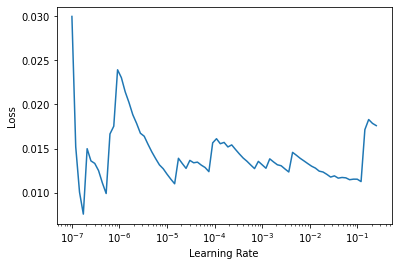

In [33]:
siamese_learner.unfreeze()

lr_min, _ = siamese_learner.lr_find()
siamese_learner.fit(n_epoch=5, lr=lr_min)

In [36]:
siamese_learner.save("snn.pkl")

Path('snn.pkl.pth')

In [39]:
# TODO: train kNN on encoded penguins_train (df)

In [40]:
from tqdm import tqdm

train_encoded = list()
for i in tqdm(range(len(dls.train_ds.tabular_pandas))):
    # get ith point from the training set
    p, _, _ = dls.train_ds.get_items(i, 0)

    # rehsape into mini-batch size 1
    p = p[0].reshape(1, -1), p[1].reshape(1, -1)

    # encode the household into output embedding space
    p_encode = siamese_learner.model.encode(p)
    train_encoded.append(p_encode)
    
ids = dls.train.get_idxs()
y_train_labels = dls.train.tabular_pandas["loan_status"]

100%|██████████| 10232/10232 [19:32<00:00,  8.72it/s]


In [41]:
import torch
import pandas as pd

train_encoded_df = pd.DataFrame(torch.stack(train_encoded).squeeze())

In [49]:
train_encoded_df

,0,1
0,0.000000,0.894329
1,10.181988,0.000000
2,10.025503,0.000000
3,10.123182,0.000000
4,10.190397,0.000000
...,...,...
10227,9.725966,0.000000
10228,0.000000,0.771123
10229,10.151201,0.000000
10230,10.220160,0.000000


In [52]:
# train_encoded_df[0].values

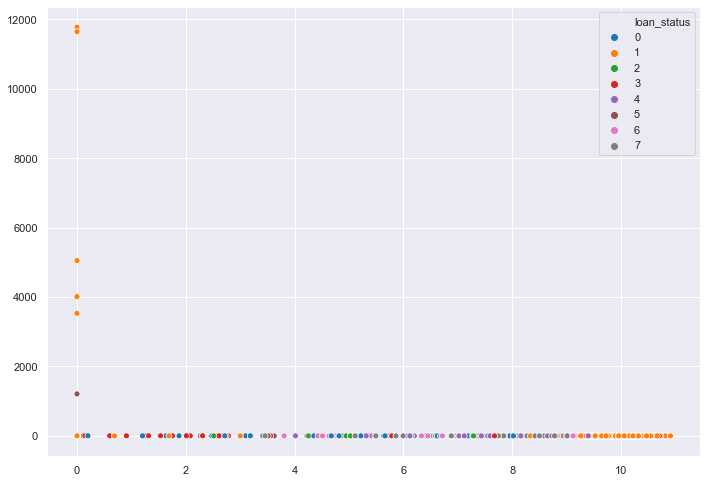

In [53]:
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(x=train_encoded_df[0].values,
                y=train_encoded_df[1].values,
                hue=y_train_labels, 
                legend='full', 
                palette="tab10")

In [54]:
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(rc={'figure.figsize':(11.7,8.27)})

tsne = TSNE()
encoded_train_tsne = tsne.fit_transform(train_encoded_df.values)

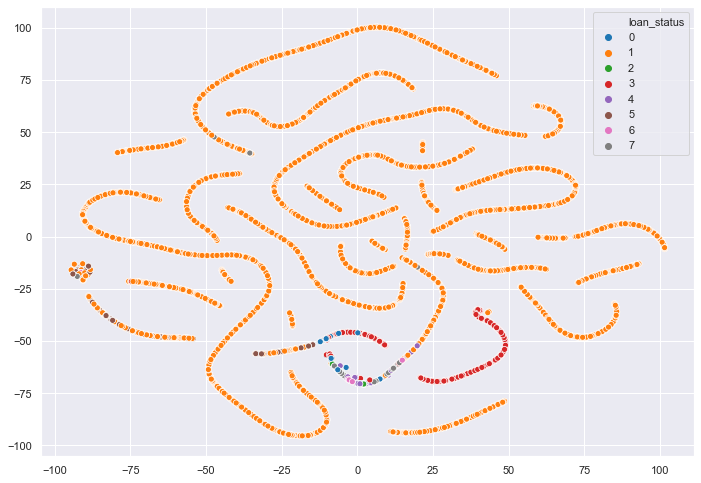

In [55]:
sns.scatterplot(x=encoded_train_tsne[:,0],
                y=encoded_train_tsne[:,1],
                hue=y_train_labels, 
                legend='full', 
                palette="tab10")

In [71]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(train_encoded_df.values, y_train_labels.values)

KNeighborsClassifier(n_neighbors=8)

We have now fit 3 models to predict penguin species - first, a multi-class Tabular learner was fit on penguins; then, a Siamese net was fit to discern likeness between pairs of penguins; lastly, a kNN supervised clustering algorithm was applied to the output of the Siamese Encoder (the manifold space) to predict species.

## Validation Set

In [60]:
from tqdm import tqdm

valid_encoded = list()
for i in tqdm(range(len(dls.valid_ds.tabular_pandas))):
    # get ith point from the training set
    p, _, _ = dls.valid_ds.get_items(i, 0)

    # rehsape into mini-batch size 1
    p = p[0].reshape(1, -1), p[1].reshape(1, -1)

    # encode the household into output embedding space
    p_encode = siamese_learner.model.encode(p)
    valid_encoded.append(p_encode)
    
valid_ids = dls.valid.get_idxs()
y_valid_labels = dls.valid.tabular_pandas["loan_status"]

100%|██████████| 1136/1136 [01:47<00:00, 10.53it/s]


In [61]:
valid_encoded_df = pd.DataFrame(torch.stack(valid_encoded).squeeze())

In [62]:
encoded_valid_tsne = tsne.fit_transform(valid_encoded_df.values)

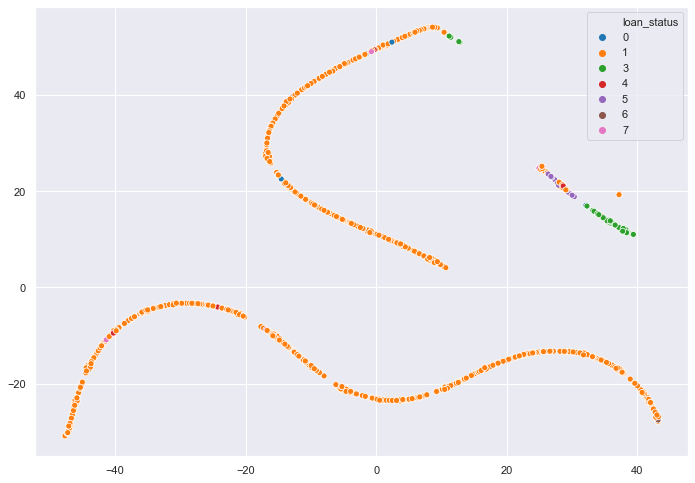

In [63]:
sns.scatterplot(x=encoded_valid_tsne[:,0],
                y=encoded_valid_tsne[:,1],
                hue=y_valid_labels, 
                legend='full', 
                palette="tab10")

In [72]:
res = pd.DataFrame(zip(knn.predict(valid_encoded_df), y_valid_labels), columns=["pred", "true"])

In [73]:
(res["pred"] == res["true"]).sum() / len(res)

0.9366197183098591

In [74]:
res

,pred,true
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1131,1,1
1132,1,1
1133,1,1
1134,1,1


In [93]:
res[res["true"] == 3]

,pred,true
7,3,3
8,3,3
30,3,3
31,3,3
67,3,3
...,...,...
941,4,3
990,4,3
1091,3,3
1124,3,3


In [103]:
from sklearn.metrics import precision_recall_fscore_support as multiclass_eval

prec, recall, fbeta, _ = multiclass_eval(res["true"].values, res["pred"].values, average="macro")

f"precision {prec}, recall {recall}, fbeta {fbeta}"

/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'precision 0.3501281532443005, recall 0.29594961730511604, fbeta 0.3135186122199109'

Text(0.5, 1.0, 'UMAP projection of the LC Loans')

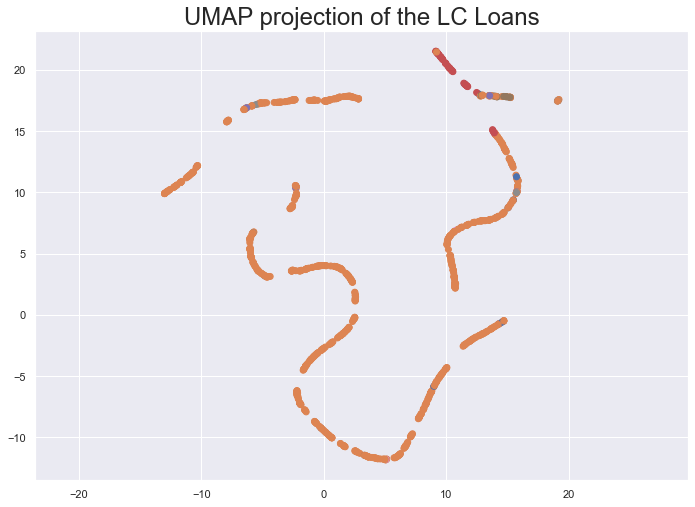

In [70]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP()

embedding = reducer.fit_transform(valid_encoded_df.values)
embedding.shape

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in y_valid_labels.values])

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the LC Loans', fontsize=24)